In [30]:
%matplotlib inline
import sys
print(sys.version)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import requests
import io
import scipy

# Update the matplotlib configuration parameters:
mpl.rcParams.update({'font.size': 18, 'font.family': 'serif', 'xtick.major.pad' : 5, 'ytick.major.pad' : 5})

3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]


In [31]:
# Loading our data in its raw form

urlGam = "https://drive.google.com/uc?export=download&id=1TvbbCV-kJeNMuIORMyiMFgH_u_CQSZhX" # Make sure the url is the raw version of the file on GitHub
downloadGam = requests.get(urlGam).content
GamRaw = pd.read_csv(io.StringIO(downloadGam.decode('utf-8')))

urlNeut = "https://drive.google.com/uc?export=download&id=1bY6ZPF3WLxfviYSSViuw1SEx1_sWxP46" # Make sure the url is the raw version of the file on GitHub
downloadNeut = requests.get(urlNeut).content
NeutRaw = pd.read_csv(io.StringIO(downloadNeut.decode('utf-8')))

In [32]:
# # Making a function to normalize any given dataframe

# from sklearn.preprocessing import MinMaxScaler


# def scaler(dataSet):
#     scaler = MinMaxScaler()
#     scaler.fit(dataSet)
#     return pd.DataFrame(scaler.transform(dataSet), columns=dataSet.columns)

# GamNormal = scaler(GamRaw)
# NeutNormal = scaler(NeutRaw)



# GamNormal.head()

In [33]:
# Add a distriction column to the data, to know which is gam and which is neut for later graphing

GamNormal["distinction"] = 1
NeutNormal["distinction"] = 0

In [34]:
# Making the training data sets

GamTrain = GamNormal.sample(frac=0.05)
NeutTrain = NeutNormal.sample(frac=0.05)

In [35]:
# Have a look at the data.

# GamTrain.head()
print(NeutTrain.shape)
NeutTrain.head()

(2176, 12)


,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom,distinction
10013,0.363841,0.156166,0.327950,0.322034,0.2,0.166913,0.363507,0.637495,0.855680,0.015366,0.972275,0
5129,0.863400,0.947900,0.038947,0.271186,0.0,0.003390,1.000000,1.000000,0.141415,0.097451,0.999606,0
16489,0.168991,0.266356,0.108905,0.033898,0.0,0.122677,0.664599,1.000000,0.990452,0.002485,0.053998,0
22146,0.004913,0.286000,0.545057,0.355932,0.2,0.398679,0.853139,0.564345,0.614269,0.006647,0.957912,0
4121,0.613344,0.634502,0.095889,0.135593,0.0,0.087510,0.574539,0.964356,0.912251,0.008329,0.811404,0


In [36]:
print(GamTrain.shape)
GamTrain.head()

(2168, 12)


,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom,distinction
40492,0.709241,0.751006,0.473072,0.478261,0.0,0.432534,0.750684,0.930013,0.955315,0.015508,0.371910,1
11046,0.602491,0.302098,0.298106,0.217391,0.0,0.309741,0.841142,0.973559,0.984022,0.002835,0.152522,1
40045,0.107675,0.540844,0.328178,0.347826,0.0,0.301196,0.735174,0.938310,0.964161,0.009215,0.292315,1
30666,0.716294,0.023023,0.680397,0.478261,0.0,0.429439,0.432121,0.924219,0.941500,0.004538,0.704368,1
5282,0.627957,0.511233,0.794671,0.565217,0.0,0.489765,0.406581,0.950418,0.943496,0.005050,0.373947,1


In [37]:
# gamTrain[['E']].describe()
GamTrain.describe()

,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom,distinction
count,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2.168000e+03,2168.000000,2168.0
mean,0.496923,0.493031,0.555085,0.406887,0.004520,0.448425,0.631152,0.936435,0.951403,8.106683e-03,0.480356,1.0
std,0.285556,0.288147,0.226772,0.126724,0.030949,0.204290,0.182170,0.064079,0.033419,8.183954e-03,0.245639,0.0
min,0.000831,0.000050,0.001291,0.000000,0.000000,0.001283,0.000000,0.082026,0.543726,7.638959e-48,0.000000,1.0
25%,0.248801,0.233306,0.363896,0.326087,0.000000,0.280909,0.509367,0.931259,0.947967,3.786107e-03,0.284404,1.0
50%,0.479889,0.493539,0.555281,0.413043,0.000000,0.433818,0.676926,0.945493,0.957728,6.086965e-03,0.386204,1.0
75%,0.745492,0.739256,0.748446,0.500000,0.000000,0.602733,0.771622,0.958947,0.966053,9.772323e-03,0.701661,1.0
max,0.996396,0.999536,0.980765,0.826087,0.400000,0.966568,1.000000,1.000000,1.000000,1.086660e-01,0.994590,1.0


In [38]:
NeutTrain.describe()

,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom,distinction
count,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.0
mean,0.439717,0.510061,0.193803,0.217021,0.023529,0.133199,0.536862,0.837670,0.808700,0.043493,0.763485,0.0
std,0.267100,0.288239,0.134418,0.136737,0.076219,0.090343,0.214767,0.157604,0.217442,0.074220,0.287057,0.0
min,0.001639,0.000111,0.000419,0.000000,0.000000,0.001611,0.055607,0.112520,0.000000,0.000000,0.000000,0.0
25%,0.203555,0.256263,0.091013,0.118644,0.000000,0.065154,0.373453,0.751347,0.784008,0.008451,0.636509,0.0
50%,0.430399,0.518500,0.169132,0.186441,0.000000,0.116560,0.516073,0.872430,0.879561,0.019063,0.902325,0.0
75%,0.669466,0.760368,0.270556,0.305085,0.000000,0.182280,0.675546,0.968320,0.937083,0.042571,0.974540,0.0
max,0.968622,0.999669,0.886043,0.915254,0.600000,0.615524,1.000000,1.000000,1.000000,0.545323,0.999734,0.0


In [39]:
# Combining Neut and Gam dataframes for a single frame for plotting

plotFrame = pd.concat([GamTrain, NeutTrain], ignore_index=True, axis=0)

print(plotFrame.shape)
plotFrame.head()

(4344, 12)


,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom,distinction
0,0.709241,0.751006,0.473072,0.478261,0.0,0.432534,0.750684,0.930013,0.955315,0.015508,0.371910,1
1,0.602491,0.302098,0.298106,0.217391,0.0,0.309741,0.841142,0.973559,0.984022,0.002835,0.152522,1
2,0.107675,0.540844,0.328178,0.347826,0.0,0.301196,0.735174,0.938310,0.964161,0.009215,0.292315,1
3,0.716294,0.023023,0.680397,0.478261,0.0,0.429439,0.432121,0.924219,0.941500,0.004538,0.704368,1
4,0.627957,0.511233,0.794671,0.565217,0.0,0.489765,0.406581,0.950418,0.943496,0.005050,0.373947,1


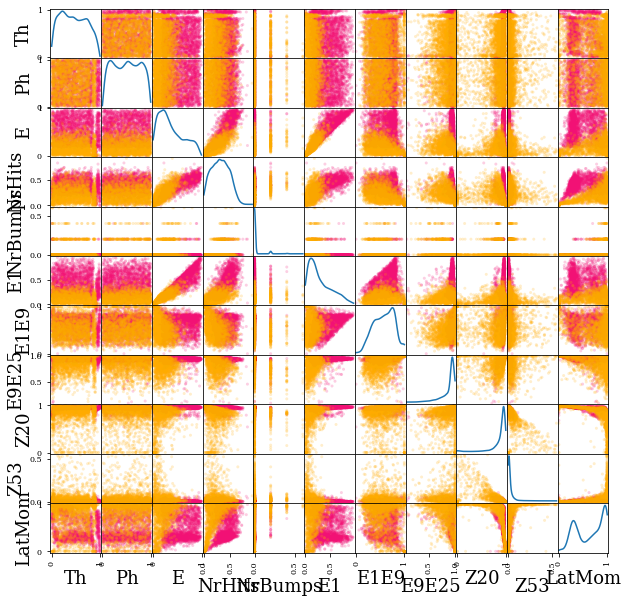

In [40]:
colors = ['#f21175', '#ffab00']

_ = pd.plotting.scatter_matrix(plotFrame[['Th','Ph','E','NrHits','NrBumps','E1','E1E9','E9E25','Z20','Z53','LatMom']], 
                               figsize=(10,10), diagonal='kde', 
                               alpha=0.2, 
                               color=[colors[x-1] for x in list(plotFrame.distinction)])

In [41]:
## data normalisation function

def NormalizeData(data, feature_list):
    """
    Normalize features in "feature_list" of dataFrame "data".
    New features will be added as columns to the dataFrame with label "_normal".
    The function returns the updated table.
    """
    
    # Dont modify the original dataFrame "data"
    data_tmp = data.copy()

    # Run over all features and create new column with "_normal"
    for feature in feature_list:
        feature_new = feature + "_normal"
        data_tmp[feature_new] = (data_tmp[feature] - data_tmp[feature].mean()) / data_tmp[feature].std()

    # Return the updated dataFrame
    return data_tmp



In [46]:
# we now normalise the features that could be correleated later

plotFrame = NormalizeData(plotFrame, ["E", "NrHits", "E1", "E1E9"])

plotFrame[["E_normal", "NrHits_normal", "E1_normal", "E1E9_normal"]].describe()

,E_normal,NrHits_normal,E1_normal,E1E9_normal
count,4.344000e+03,4.344000e+03,4.344000e+03,4.344000e+03
mean,1.362579e-15,-3.141952e-15,6.454321e-16,-5.404427e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.439980e+00,-1.919204e+00,-1.296646e+00,-2.853275e+00
25%,-8.172225e-01,-7.715393e-01,-7.965276e-01,-7.914895e-01
50%,-2.491660e-01,-4.120717e-02,-3.150720e-01,6.631767e-02
75%,7.376356e-01,7.571683e-01,6.635010e-01,8.020595e-01
max,2.337668e+00,3.714787e+00,3.030686e+00,2.033136e+00


In [12]:
# If you don't have seaborn then run the line below
# !pip install seaborn

In [16]:
import seaborn as sns
from sklearn import cluster

def getClusters(k, frame, variables):
    '''
    Plots two parameters from a dataframe with cluster centers.
    
    Parameters:
    k (int)                  -- Number of clusters
    frame (pandas dataframe) -- The dataframe to examine
    variables (numpy array)  -- Columns to examine
    '''
    
    start = np.random.rand(k, 2)
    
    kmeans = cluster.KMeans(n_clusters=k, max_iter=1000, init=start, n_init=1)
    kmeans.fit(frame[variables])
    
    labels    = kmeans.labels_
    centroids = kmeans.cluster_centers_
    nriter    = kmeans.n_iter_
    
    centroids = centroids.reshape(k, 2)
    centroidFrame = pd.DataFrame(centroids, columns =['x', 'y'])
    
    fig, axes = plt.subplots(nrows=1, ncols=1,
                            figsize=(8, 8),
                            layout="constrained"
                            )

    sns.scatterplot(data=frame, x=variables[0], y=variables[1], marker='.', hue='distinction', ax=axes).set_title(f'{variables[0]} v.s. {variables[1]}')
    sns.scatterplot(data=centroidFrame, x='x', y='y', marker='X', color='black', s=200, ax=axes)
    plt.show()


In [17]:
getClusters(2, plotFrame, ['E1', 'LatMom'])

TypeError: __init__() got an unexpected keyword argument 'layout'

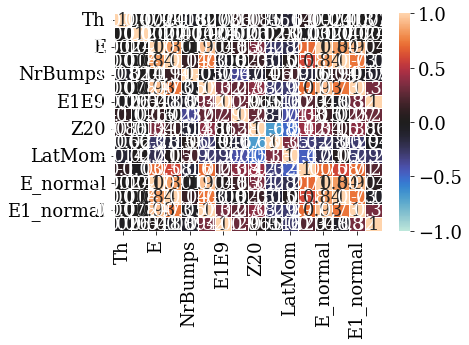

<Figure size 36000x36000 with 0 Axes>

In [57]:
# Heatmap for data correlations

sns.heatmap(plotFrame.corr(), 
            annot=True,
            linewidths=0.5,
            vmin=-1,
            vmax=1,
            center=0,
            cbar=True)

plt.figure(figsize=(500, 500))
plt.show()

#plotFrame.head()

In [58]:
#
# The engine code behind the ML algorithm used in this example.
# We make use of classifier "classifier":
#

def Classify(classifier, data, params,
             prop_test=0.5, feature_list=['E_normal','Nr_Hits'], 
             plot_ds=False, plot_tree=False, plot_network=False):
    """
    Use "classifier" algorithm to classify dataset data. Use feature list feature_list
    and use prop_test fraction of the data as test sample, rest for training.
    The function returns an updated dataset including a column with predicted class.
    """
    
    assert 0<prop_test<1
     
    #
    # make a copy of the dataframe. The original table will not be altered.
    #
    data_tmp = data.copy()
    #
    # Add a column specifying whether event is used for training or for testing
    #
    data_tmp['is_train'] = np.random.uniform(0, 1, len(data_tmp)) <= (1-prop_test)
    #
    # Extract two seperate datasets for training (train) and testing (test)
    #
    train, test = data_tmp[data_tmp['is_train']==True], data_tmp[data_tmp['is_train']==False]
    
    
    if   (classifier=="DT"):
        # we create an instance of Decision Tree Classifier.
        clf = tree.DecisionTreeClassifier(criterion='entropy',
                                          min_impurity_decrease=params[0],
                                          max_depth=params[1])
    elif (classifier=="RF"):
        # we create an instance of Random Forest Classifier.
        clf = RandomForestClassifier(n_estimators=params[0], 
                                     max_features=params[1])
    elif (classifier=="kNN"):
        # we create an instance of kNN Classifier.
        clf = neighbors.KNeighborsClassifier(n_neighbors=params[0])
    elif (classifier=="MLP"):
        # we create an instance of MLP Classifier.
        clf = MLPClassifier(solver='lbfgs', activation='logistic', #solver=quasi-Newton, activation=sigmoid
                            max_iter=5000, 
                            hidden_layer_sizes=params[0])
    else:
        print(" Classifier not implemented: ", classifier)
        return None
    
    # Fit the data with the selected classifier...
    clf.fit(train[feature_list],train['distinction'])
    
    #evaluate the training points
    trainpred = clf.predict(train[feature_list]) # majority vote result
    train['prediction'] = [x for x in trainpred]
   
    # Predict on the testing points       
    testpred = clf.predict(test[feature_list])   # majority vote result
    test['prediction'] = [x for x in testpred]
 
    data_update = train.append(test)
     
    # Make it possible to plot the decision surface if plot_ds flag set to True and nr of features equals 2.
    if (plot_ds) & (len(feature_list)==2):
        PlotDecisionSurface(clf,data_update,feature_list)

    # In the case the classifier is a decision tree, allow for the possibility to plot the tree, 
    # only when plot_tree is set to True.
    if (plot_tree) & (classifier=="DT"): 
        PlotTree(clf, feature_list)
  
    # Plot the network structure in case of multi-layer perceptron
    # Only when plot_network flag is set to True. Comment out if VisNN code not available!
    if (plot_network) & (classifier=="MLP"):   
        network_structure = np.hstack(([len(feature_list)], np.asarray(clf.hidden_layer_sizes), [data['fruitid'].nunique()]))
        # Draw the Neural Network with weights given by clf.coefs_
        network=VisNN.DrawNN(network_structure, clf.coefs_)
        network.draw()
            
    # Return the updated version of the dataFrame including labels "is_train" and "predicted".
    return data_update


In [59]:
#
# GetNrOfSuccesses(dataFrame): returns fraction of succesfull classifications for training and test 
#                              part of the data table and used as the metric for the fruit analysis!
#

def GetNrOfSuccesses(data):
    """
    Reads as input DataFrame "data" and return the fraction of successfull classifications of
    the training and test part of the table. This function only works with an updated DataFrame
    that includes the columns "is_train" and "prediction", generated by Classify() function.
    """
    
    nrtrain_instances = len(data[(data.is_train == True)])
    nrtest_instances  = len(data[(data.is_train == False)])
    
    nrtrain_success = len(data[(data.is_train == True)  & (data.prediction == data.fruitid)])
    nrtest_success  = len(data[(data.is_train == False) & (data.prediction == data.fruitid)])
    
    return (nrtrain_success/nrtrain_instances), (nrtest_success/nrtest_instances)

In [60]:
#
# PlotTree: a procedure that displays the tree structure of classifier clf...
#

def PlotTree(clf, feature_list):
    """
    Plot the decision tree of classifier "clf" with list of features given in "feature_list".
    The function creates a file called "simple.dotfile" and corresponding "simpletree.png".
    To generate the png-file, "dot" needs to be installed on your OS.
    The png-file is displayed in the notebook.
    """
    dot_data = StringIO() 
    tree.export_graphviz(clf, out_file=dot_data)
    tree_string = dot_data.getvalue()
    tree_string = re.sub('samples = [0-9]+\\\\n', '', tree_string) # Remove line starting with samples = ...
    for i, feature in enumerate(feature_list):
        tree_string = re.sub('X\[{}\]'.format(i), feature, tree_string) # Replace X[..] with true feature name
    with open('simple.dotfile', 'w+') as f:
        f.write(tree_string)
    !dot -Tpng simple.dotfile > simpletree.png  # "dot" needs to be installed on your OS; see info https://graphviz.org/documentation/ 
    display(Image(filename ='simpletree.png'))
    return  

In [61]:
#
# PlotDecisionSurface: function that creates decision surface based on classifier clf
# and features in feature_list of dataFrame data. It uses "meshgrid" of numpy to generate
# grid of points to evaluate by classifier. For plotting, it uses "pcolormesh" of matplotlib.
#

def PlotDecisionSurface(clf, data, feature_list, label='fruitid', step=0.01):
    """
    Function that creates a decision surface of classifier "clf"
    together with features from the two entries of the "features_list" of "data"
    """
    X = data[feature_list[0]].values
    Y = data[feature_list[1]].values
    
    # colors associated with the three classes, light is used for surface and bold for datapoints
    cmap_light = ListedColormap(['#ffde9e', '#b8ea9d', '#ffbaba'])
    cmap_bold  = ListedColormap(['#ff8c28', '#11bb11', '#ff0000'])
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max] x [y_min, y_max].
    x_min, x_max = X.min(), X.max()
    y_min, y_max = Y.min(), Y.max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Put the result into a color plot
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
    # Plot the data points
    plt.scatter(X, Y, s=40, c=data[label], cmap=cmap_bold)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel(feature_list[0])
    plt.ylabel(feature_list[1])
    plt.show()
    return


In [63]:
#
# Let's test Classify function for a decision tree, and see what it creates ;-)
#
classifier            = 'DT'
min_impurity_decrease = 0.3
max_depth             = None
params                = [min_impurity_decrease, max_depth]
prop_test             = 0.5
feature_list          = ['E_normal', 'Nr_Hits_normal'] #Q: do you really have to use _normal features?
plot_ds               = True
plot_tree             = True
plot_network          = False

data_new = Classify(classifier=classifier, data=plotFrame, params=params, prop_test=prop_test, feature_list=feature_list, 
                    plot_ds=plot_ds, plot_tree=plot_tree, plot_network=plot_network)

train_success, test_success = GetNrOfSuccesses(data_new)
print('Success rate: ', train_success, test_success)

NameError: name 'tree' is not defined